# Visualizing Body Data
AMASS uses [MoSh++](https://amass.is.tue.mpg.de) pipeline to fit [SMPL+H body model](https://mano.is.tue.mpg.de/) to a human motion capture (mocap) session. [These mocaps](https://amass.is.tue.mpg.de/dataset) are from different publicly available datasets. A single data file in amass has the parameters to control gender, pose, shape, global translation and soft tissue dynamics in correspondence with the original motion capture sequence. Here we present code snippets to create a body image with these parameters. Since a mocap is a time sequence you visualize the "moshed" per frame results.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sys, os
import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c

In [2]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We assume you have downloaded the required body model and put that in body_models directory of this repository.
For SMPL-H download it from http://mano.is.tue.mpg.de/ and DMPLs you can obtain from http://smpl.is.tue.mpg.de/downloads.
If you use any of these models in your research please follow their respective citation rules.
One thing to note is that you can obtain basic SMPL+H model from their [website](http://mano.is.tue.mpg.de/), however, this model doesn't have dynamic shape blendshapes, e.g. DMPLs, and has only 10 betas. Doing so will reduce the accuracy of results. 

In [3]:
from human_body_prior.body_model.body_model import BodyModel

bm_path = '../body_models/smplh/male/model.npz'
dmpl_path = '../body_models/dmpls/male/model.npz'

num_betas = 10 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, num_dmpls=num_dmpls, path_dmpl=dmpl_path).to(comp_device)
faces = c2c(bm.f)

In [4]:
npz_bdata_path = '../github_data/amass_sample.npz' # the path to body data
bdata = np.load(npz_bdata_path)
print('Data keys available:%s'%list(bdata.keys()))
print('Vector poses has %d elements for each of %d frames.'%(bdata['poses'].shape[1], bdata['poses'].shape[0]))
print('Vector dmpls has %d elements for each of %d frames.'%(bdata['dmpls'].shape[1], bdata['dmpls'].shape[0]))
print('Vector trams has %d elements for each of %d frames.'%(bdata['trans'].shape[1], bdata['trans'].shape[0]))
print('Vector betas has %d elements constant for the whole sequence.'%bdata['betas'].shape[0])
print('The subject of the mocap sequence is %s.'%bdata['gender'])

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
Vector poses has 156 elements for each of 601 frames.
Vector dmpls has 8 elements for each of 601 frames.
Vector trams has 3 elements for each of 601 frames.
Vector betas has 16 elements constant for the whole sequence.
The subject of the mocap sequence is male.


The provided sample data also has the original mocap marker data. In the real AMASS dataset, only markers for the test set are included. For the rest of the subsets you can obtain the marker data from their respective websites.
In the following we make PyTorch tensors for parameters controlling different part of the body model.

**Please note how pose indices for different body parts work.**

In [5]:
fId = 0 # frame id of the mocap sequence

root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

Import the required files for viewing out mesh:

In [6]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

### Visualize betas and pose_body
Let's see how our body looks like using the pose and body shape parameters.

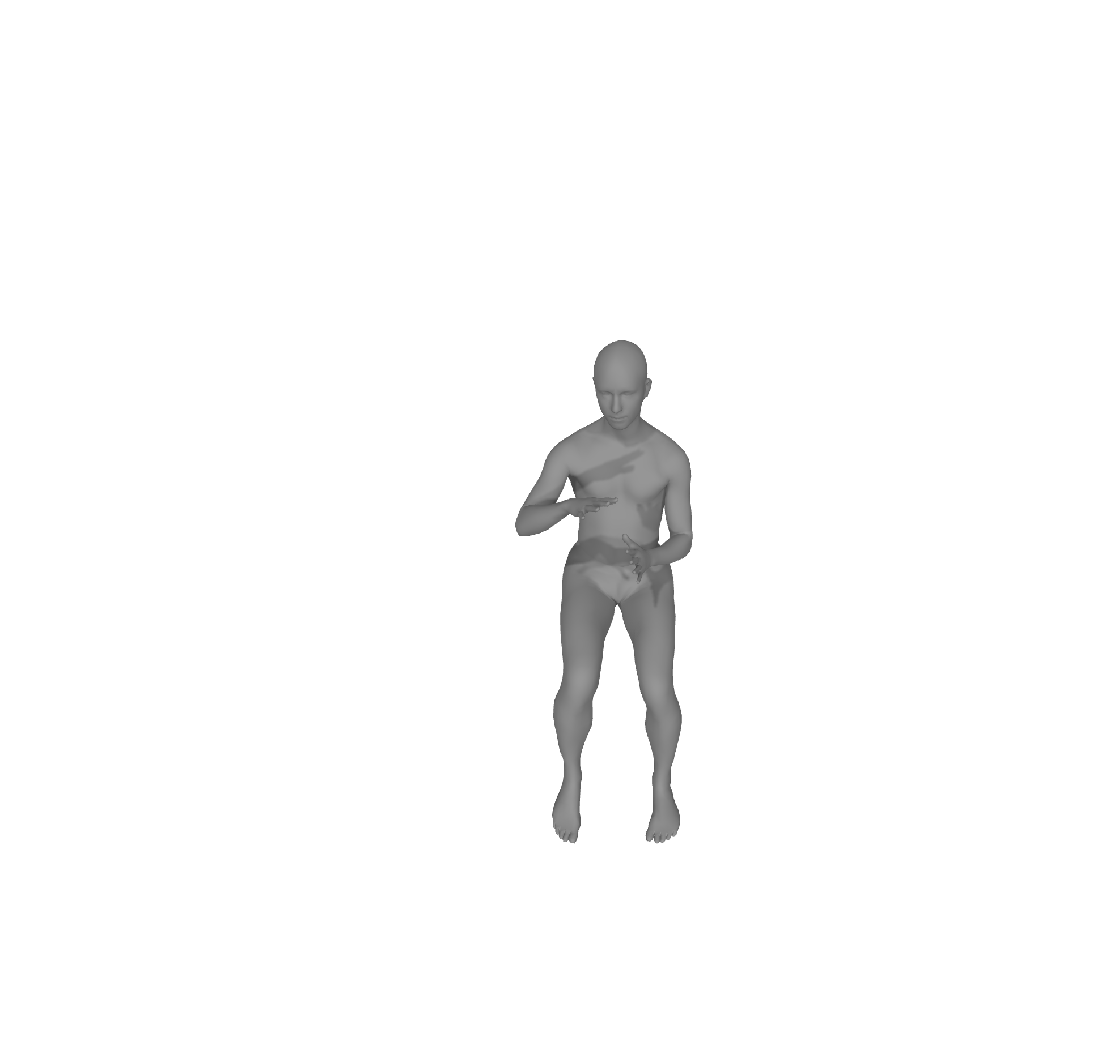

In [7]:
body = bm(pose_body=pose_body, betas=betas)
body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=False)
show_image(body_image)

We see a male subject sitting and havig the hands open. 
Let's articulate the fingers as well:

### Visualize pose hands
To articulate fingers we use the 66:156 pose vector elements.

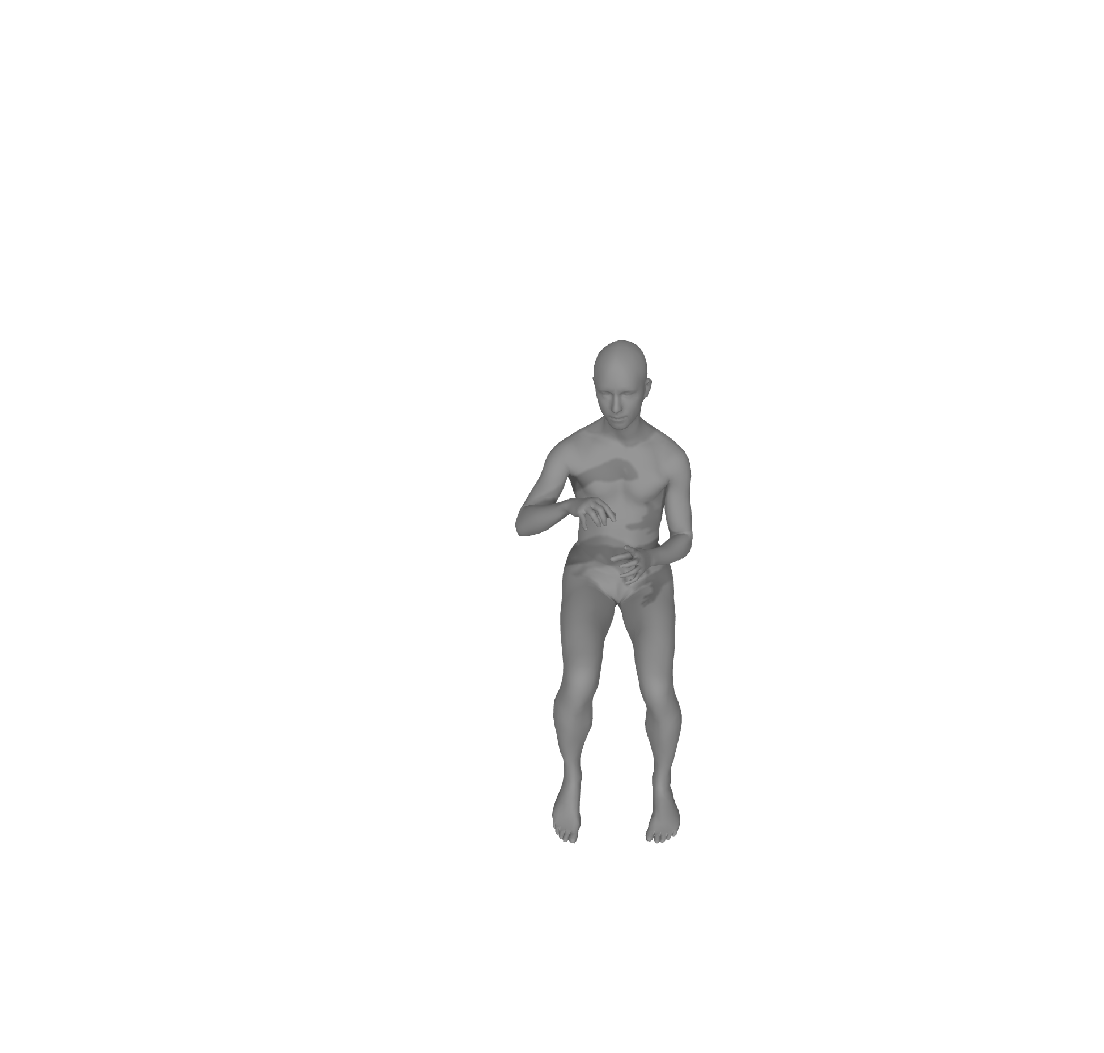

In [8]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wfingers])
body_image_wfingers = mv.render(render_wireframe=False)
show_image(body_image_wfingers)

It seems that the subject is holding something with one hand.

### Visualize body joints

Our body model has also joint locations. You can read their location by accesing **Jtr** attribute of the returned body and visualize them as spheres. Here we render the body transparently to visualize the joints.

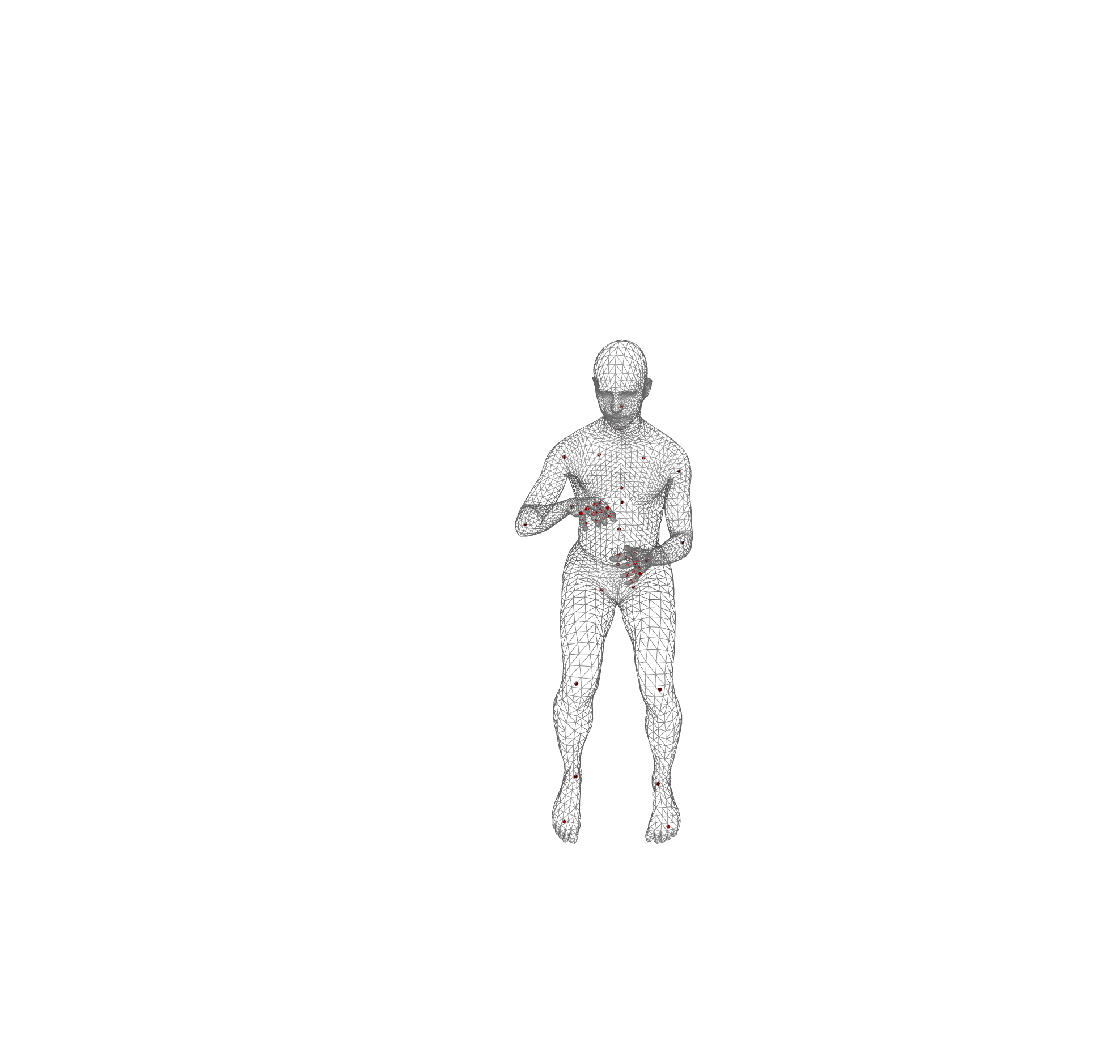

In [9]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
joints = c2c(body.Jtr[0])
joints_mesh = points_to_spheres(joints, vc = colors['red'], radius=0.005)
mv.set_static_meshes([body_mesh_wfingers] + joints_mesh)
body_image_wfingers_joints = mv.render(render_wireframe=True)
show_image(body_image_wfingers_joints)

### Visualize DMPLs

You can control the soft tissue dynamics with dmpl parameters. Please have in mind, by nature of dmpl parameters being dynamic, the better appear when animation the whole sequence. Refer to full renders of the parameter sequences in our [website](https://amass.is.tue.mpg.de/).

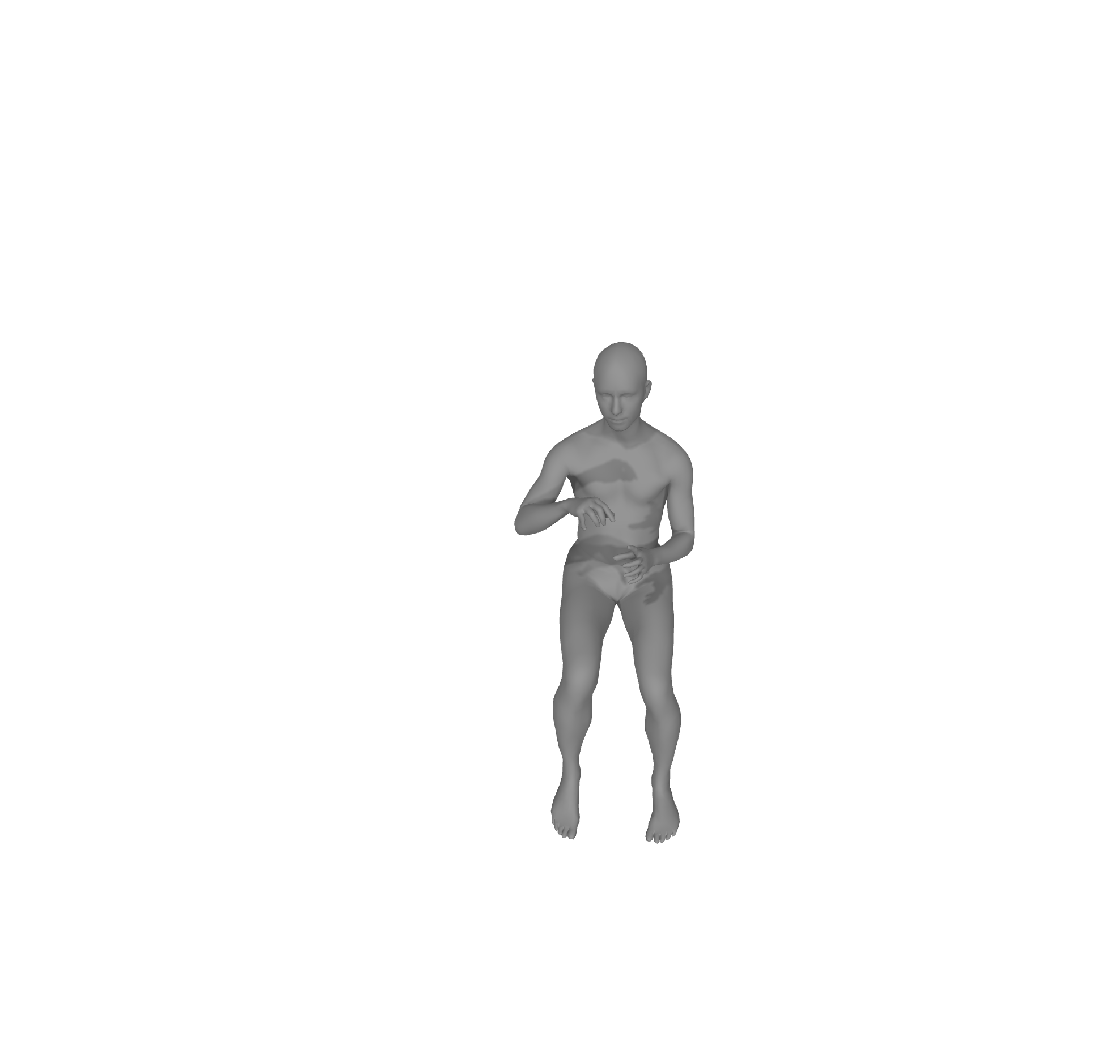

In [10]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls)
body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wdmpls])
body_image_wdmpls = mv.render(render_wireframe=False)
show_image(body_image_wdmpls)

### Visualizing the global root orientation

In the above examples we dont use the global translation or rotation. To be able to see the subject from the front. However, we can globally control the character position and orientation with trans, and root_orient parameters respectively.

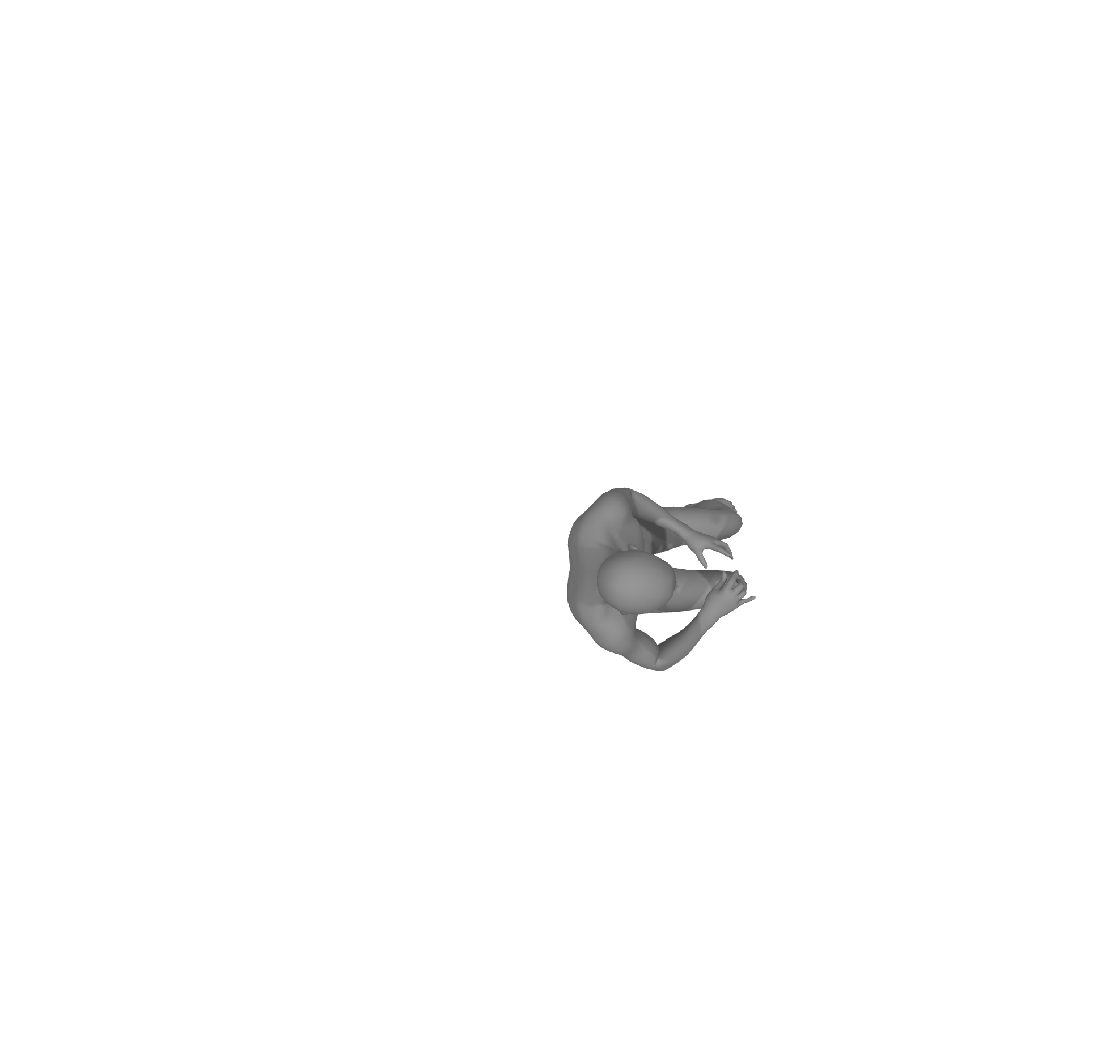

In [11]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)

One can also rotate the above body into front view by transforming the mesh.

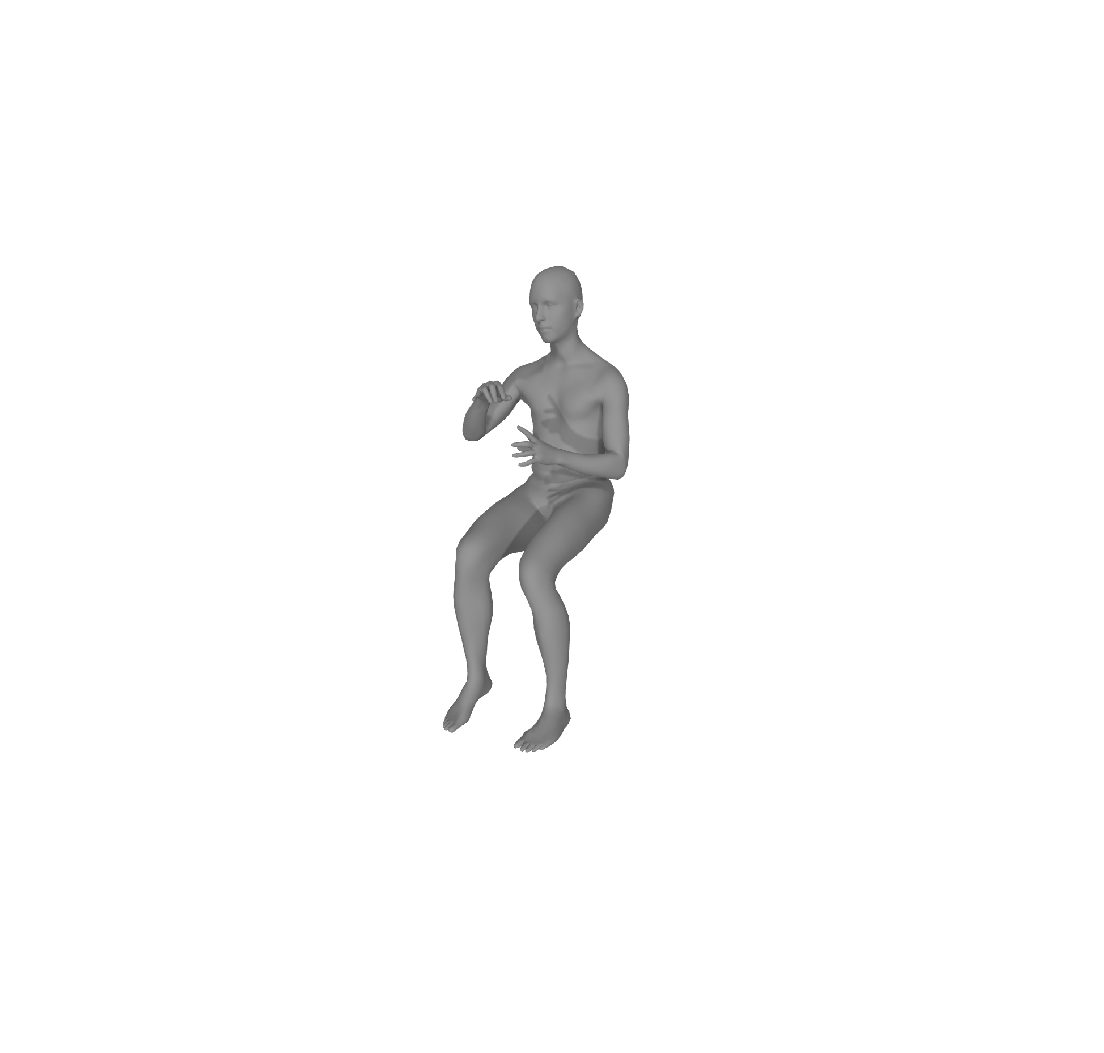

In [12]:
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(-90, (0, 0, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(30, (1, 0, 0)))

mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)